# Find out on which weekday people bike the most with groupby and aggregate

In [ ]:
SYFT_VERSION = ">=0.8.1b0,<0.9"
package_string = f'"syft{SYFT_VERSION}"'
# !pip install {package_string} -f https://whls.blob.core.windows.net/unstable/index.html -q

: 

In [2]:
import syft as sy
sy.requires(SYFT_VERSION)

ModuleNotFoundError: No module named 'syft'

In [3]:
node = sy.orchestra.launch(name="pandas-test-domain-1", reset=True)

SQLite Store Path:
!open file:///var/folders/f1/h55w4kj150x0s8c3jwhkkygw0000gn/T/281e55cb3425460e864682cfb4672fcb.sqlite



# Data owner: upload data

In [4]:
root_domain_client = node.login(email="info@openmined.org", password="changethis")

## Load data

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.parser import parse
from pandas._libs.tslibs.timestamps import Timestamp
from syft.service.project.project import Project
from syft.util.util import autocache, PANDAS_DATA

In [6]:
df = pd.read_csv(autocache(f"{PANDAS_DATA}/bikes.csv"), sep=';', encoding='latin1', parse_dates=['Date'], dayfirst=True, index_col='Date')
df[:3]

,Berri 1,Brébeuf (données non disponibles),Côte-Sainte-Catherine,Maisonneuve 1,Maisonneuve 2,du Parc,Pierre-Dupuy,Rachel1,St-Urbain (données non disponibles)
Date,,,,,,,,,
2012-01-01,35,NaN,0,38,51,26,10,16,NaN
2012-01-02,83,NaN,1,68,153,53,6,43,NaN
2012-01-03,135,NaN,2,104,248,89,3,58,NaN


In [7]:
f"{PANDAS_DATA}/bikes.csv".rsplit('/', 1)
len(df)

310

## Create mock data

In [7]:
import numpy as np
from random import randint

def get_mock_int(i, var=10):
    base = 100 + int(np.cos(i/10) * 50)
    return randint(max(base-var, 1),max(1, base+var))

def get_mock_date(i):
    return str(parse('Jun 1 2005').date() + timedelta(days=i))

# some randomness
r = [(randint(1, 40), randint(1, 40)) for _ in range(7)]

def get_mock_row(i):
    res = [get_mock_int(i+r[j][0], r[j][1]) for j in range(7)]
    # add NaNs in the second and 10th col
    res.insert(1, None), res.insert(9, None)
    return res
    

In [8]:
mock = pd.DataFrame(index=[Timestamp(get_mock_date(i)) for i in range(len(df))],
                    data=[get_mock_row(i) for i in range(len(df))],
                    columns=df.columns)

Upload the data

In [9]:
dataset = sy.Dataset(name="bikes2",
                     asset_list=[sy.Asset(name="bikes", data=df, mock=mock, mock_is_real=False)])
root_domain_client.upload_dataset(dataset)


100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

Uploading: bikes


<class 'syft.service.response.SyftSuccess'>: Dataset Added

## create Data scientist

In [10]:
user = root_domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

# todo: give user data scientist role

guest_domain_client = node.client

guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

# Data Scientist: create result pointer

## Download mock and submit project

### Get mock

In [11]:
ds = guest_domain_client.datasets[0]

In [12]:
asset = ds.assets["bikes"]

In [13]:
asset

```python
Asset: bikes
Pointer Id: ce283f66d51a435e86ccef64ba2941f3
Description: None
Total Data Subjects: 0
Shape: (310, 9)
Contributors: 0

```

In [14]:
bikes_pointer = asset.mock

### Adding a 'weekday' column to our dataframe

First, we need to load up the data. We've done this before.

<AxesSubplot: >

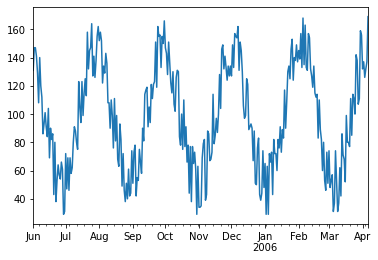

In [15]:
bikes_pointer['Berri 1'].plot()

Next up, we're just going to look at the Berri bike path. Berri is a street in Montreal, with a pretty important bike path. I use it mostly on my way to the library now, but I used to take it to work sometimes when I worked in Old Montreal.

So we're going to create a dataframe with just the Berri bikepath in it

In [16]:
berri_bikes_pointer = bikes_pointer[['Berri 1']].copy()

In [17]:
berri_bikes_pointer[:5]

,Berri 1
2005-06-01,131
2005-06-02,147
2005-06-03,147
2005-06-04,141
2005-06-05,129


Next, we need to add a 'weekday' column. Firstly, we can get the weekday from the index. We haven't talked about indexes yet, but the index is what's on the left on the above dataframe, under 'Date'. It's basically all the days of the year.

In [18]:
berri_bikes_pointer.index

```python
TwinPointer(Mock)
```
DatetimeIndex(['2005-06-01', '2005-06-02', '2005-06-03', '2005-06-04',
               '2005-06-05', '2005-06-06', '2005-06-07', '2005-06-08',
               '2005-06-09', '2005-06-10',
               ...
               '2006-03-28', '2006-03-29', '2006-03-30', '2006-03-31',
               '2006-04-01', '2006-04-02', '2006-04-03', '2006-04-04',
               '2006-04-05', '2006-04-06'],
              dtype='datetime64[ns]', length=310, freq=None)

You can see that actually some of the days are missing -- only 310 days of the year are actually there. Who knows why.

Pandas has a bunch of really great time series functionality, so if we wanted to get the day of the month for each row, we could do it like this:

In [19]:
berri_bikes_pointer.index.day

```python
TwinPointer(Mock)
```
Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            28, 29, 30, 31,  1,  2,  3,  4,  5,  6],
           dtype='int64', length=310)

We actually want the weekday, though:

In [20]:
berri_bikes_pointer.index.weekday

```python
TwinPointer(Mock)
```
Int64Index([2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
            ...
            1, 2, 3, 4, 5, 6, 0, 1, 2, 3],
           dtype='int64', length=310)

These are the days of the week, where 0 is Monday. I found out that 0 was Monday by checking on a calendar.

Now that we know how to get the weekday, we can add it as a column in our dataframe like this:

In [21]:
berri_bikes_pointer

,Berri 1
2005-06-01,131
2005-06-02,147
2005-06-03,147
2005-06-04,141
2005-06-05,129
...,...
2006-04-02,137
2006-04-03,126
2006-04-04,132
2006-04-05,137


In [22]:
# d1 = berri_bikes_pointer.syft_action_data
# d2 = berri_bikes_pointer.index.weekday.syft_action_data

In [23]:
# d1['weekday'] = d2


In [24]:
# d1

In [25]:
berri_bikes_pointer['weekday'] = berri_bikes_pointer.index.weekday

In [26]:
# root_domain_client = node.login(email="info@openmined.org", password="changethis")

In [27]:
# berri_bikes_pointer.get_from(root_domain_client)

In [28]:
# berri_bikes_pointer

In [29]:
# import pandas

In [30]:
# pandas.core.indexes.numeric.Int64Index([1,2,3]).values

In [31]:
# berri_bikes_pointer.loc[:,'weekday'] = berri_bikes_pointer.index.weekday
berri_bikes_pointer[:5]

,Berri 1,weekday
2005-06-01,131,2
2005-06-02,147,3
2005-06-03,147,4
2005-06-04,141,5
2005-06-05,129,6


### Adding up the cyclists by weekday

This turns out to be really easy!

Dataframes have a `.groupby()` method that is similar to SQL groupby, if you're familiar with that. I'm not going to explain more about it right now -- if you want to to know more, the [documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) is really good.

In this case, `berri_bikes.groupby('weekday').aggregate(sum)` means "Group the rows by weekday and then add up all the values with the same weekday".

In [32]:
# res = berri_bikes_pointer.groupby('weekday')

In [33]:
# res.syft_node_uid

In [34]:
from syft.util.util import get_fully_qualified_name

In [35]:
get_fully_qualified_name(sum)

'builtins.sum'

In [36]:
import inspect

In [37]:
sum

<function sum(iterable, /, start=0)>

In [38]:
# frmo builtins im

In [39]:
import builtins

In [40]:
import types

In [41]:
# inspect.isfunction(np.sum) isinstance(sum, types.BuiltinFunctionType)

In [42]:
def get_function_name(x):
    return f"{x.__module__}.{x.__name__}"

In [43]:
get_function_name(np.sum)

'numpy.sum'

In [44]:
sum.__module__

'builtins'

In [45]:
np.sum.__module__

'numpy'

In [46]:
sum.__module__

'builtins'

In [47]:
sum.__name__

'sum'

In [48]:
from syft.serde.recursive import TYPE_BANK

In [49]:
# TYPE_BANK["builtins.builtin_function_or_method"]

In [50]:
x = type(np.sum)

In [51]:
x.__module__

'builtins'

In [52]:
x.__name__

'function'

In [53]:
builtins.__dict__.keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__build_class__', '__import__', 'abs', 'all', 'any', 'ascii', 'bin', 'breakpoint', 'callable', 'chr', 'compile', 'delattr', 'dir', 'divmod', 'eval', 'exec', 'format', 'getattr', 'globals', 'hasattr', 'hash', 'hex', 'id', 'input', 'isinstance', 'issubclass', 'iter', 'len', 'locals', 'max', 'min', 'next', 'oct', 'ord', 'pow', 'print', 'repr', 'round', 'setattr', 'sorted', 'sum', 'vars', 'None', 'Ellipsis', 'NotImplemented', 'False', 'True', 'bool', 'memoryview', 'bytearray', 'bytes', 'classmethod', 'complex', 'dict', 'enumerate', 'filter', 'float', 'frozenset', 'property', 'int', 'list', 'map', 'object', 'range', 'reversed', 'set', 'slice', 'staticmethod', 'str', 'super', 'tuple', 'type', 'zip', '__debug__', 'BaseException', 'Exception', 'TypeError', 'StopAsyncIteration', 'StopIteration', 'GeneratorExit', 'SystemExit', 'KeyboardInterrupt', 'ImportError', 'ModuleNotFoundError', 'OSError', 'EnvironmentError', 'IOEr

In [54]:
type(sum)

builtin_function_or_method

In [55]:
sy.deserialize(sy.serialize(np.median))

<function numpy.median(a, axis=None, out=None, overwrite_input=False, keepdims=False)>

In [56]:
# %debug

In [57]:
sum

<function sum(iterable, /, start=0)>

In [58]:
weekday_counts_pointer = berri_bikes_pointer.groupby('weekday').aggregate(sum)
weekday_counts_pointer

,Berri 1
weekday,
0,4288
1,4289
2,4439
3,4383
4,4354
5,4341
6,4308


It's hard to remember what 0, 1, 2, 3, 4, 5, 6 mean, so we can fix it up and graph it:

In [59]:
# weekday_counts.index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# weekday_counts

<AxesSubplot: xlabel='weekday'>

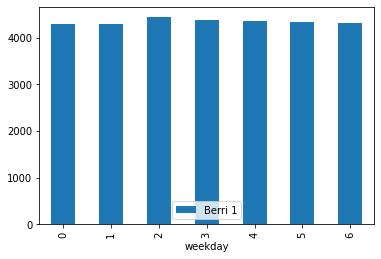

In [60]:
weekday_counts_pointer.plot(kind='bar')

So it looks like Montrealers are commuter cyclists -- they bike much more during the week. Neat!

### Putting it together

Now we want to request the real result.

In [61]:
weekday_counts_pointer.request(guest_client)

```python
class Request:
  id: str = aadb79d4415f40cf996acfebb55695a6
  requesting_user_verify_key: str = 277051fc8a5f20bd50d805b96c6891f431782c7cefb03478191bf9535daf61eb
  approving_user_verify_key: str = None
  request_time: str = 2023-05-30 16:32:49
  approval_time: str = None
  status: str = RequestStatus.PENDING
  node_uid: str = 281e55cb3425460e864682cfb4672fcb
  request_hash: str = "cfffa59bed06cffc0ce0629d73c6d69c8e35fd0c542bc3236dbc14bbf21ef71c"
  changes: str = [syft.service.request.request.ActionStoreChange]

```

# Data owner: approve result

In [62]:
root_domain_client = node.login(email="info@openmined.org", password="changethis")

In [63]:
root_domain_client.api.services.request[0].approve()

<class 'syft.service.response.SyftSuccess'>: Request aadb79d4415f40cf996acfebb55695a6 changes applied

# Data scientist: fetch result

In [64]:
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

real_result = weekday_counts_pointer.get_from(guest_client)

real_result

,Berri 1
weekday,
0,134298
1,135305
2,152972
3,160131
4,141771
5,101578
6,99310


<AxesSubplot: xlabel='weekday'>

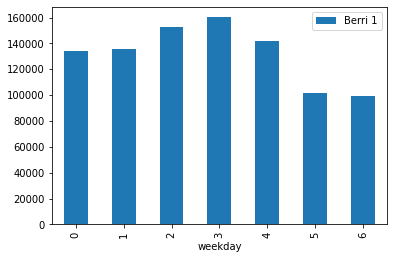

In [65]:
real_result.plot(kind='bar')